In [1]:
library(MASS)
library(nnet)
library(caret)
library(plotmo)
library(readr)
library(faraway)
library(ggplot2)
library(glmnet)
library(e1071)
library(randomForest)

Warning message:
"package 'nnet' was built under R version 3.6.3"Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'plotmo' was built under R version 3.6.3"Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos
Warning message:
"package 'TeachingDemos' was built under R version 3.6.3"Warning message:
"package 'faraway' was built under R version 3.6.3"
Attaching package: 'faraway'

The following object is masked from 'package:lattice':

    melanoma

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:g

# Load Data and Final Clean

In [2]:
df <- read.csv(file="cleaned_data_0330.csv",sep=",",header=TRUE)
df = df[,-1]
dim(df)

[1] 2470   47

## Scale and center some variables:

In [3]:
mean_age = mean(df$Start_age)
sd_age = sd(df$Start_age)
df$s_start_age = round((df$Start_age - mean_age)/sd_age,5)
mean_net = mean(df$net_cost)
sd_net = sd(df$net_cost)
df$s_net_cost = round((df$net_cost - mean_net)/sd_net,5)
mean_year = mean(df$Start_year)
sd_year = sd(df$Start_year)
df$s_start_year = round((df$Start_year - mean_year)/sd_year,5)
av_net_cost = ifelse(df$Valid.term > 0, df$net_cost / df$Valid.term, df$net_cost)
av_mean_net = mean(av_net_cost)
av_sd_net = sd(av_net_cost)
df$avs_net_cost = round((av_net_cost - av_mean_net)/av_sd_net,5)
mean_Average.Precol.GPA = mean(df$Average.Precol.GPA)
sd_Average.Precol.GPA = sd(df$Average.Precol.GPA)
df$Precol.GPA = round((df$Average.Precol.GPA - mean_Average.Precol.GPA)/sd_Average.Precol.GPA,5)
mean_GRE.Combined.General.Write.Score = mean(df$GRE.Combined.General.Write.Score)
sd_GRE.Combined.General.Write.Score = sd(df$GRE.Combined.General.Write.Score)
df$GRE_Write = round((df$GRE.Combined.General.Write.Score - mean_GRE.Combined.General.Write.Score)/sd_GRE.Combined.General.Write.Score,5)
mean_GRE.Combined.Quantitative.Score = mean(df$GRE.Combined.Quantitative.Score)
sd_GRE.Combined.Quantitative.Score = sd(df$GRE.Combined.Quantitative.Score)
df$GRE.Quant = round((df$GRE.Combined.Quantitative.Score - mean_GRE.Combined.Quantitative.Score)/sd_GRE.Combined.Quantitative.Score,5)
mean_GRE.Combined.General.Verbal.Score = mean(df$GRE.Combined.General.Verbal.Score)
sd_GRE.Combined.General.Verbal.Score = sd(df$GRE.Combined.General.Verbal.Score)
df$GRE.Verbal = round((df$GRE.Combined.General.Verbal.Score - mean_GRE.Combined.General.Verbal.Score)/sd_GRE.Combined.General.Verbal.Score,5)
mean_GMAT.Score = mean(df$GMAT.Score)
sd_GMAT.Score = sd(df$GMAT.Score)
df$GMAT.Score = round((df$GMAT.Score - mean_GMAT.Score)/sd_GMAT.Score,5)
mean_gpa = mean(df$Average_GPA)
sd_gpa = sd(df$Average_GPA)
df$average_gpa = round((df$Average_GPA - mean_gpa)/sd_gpa,2)

In [4]:
# mean_SAPC1 = mean(df$SAPC1)
# sd_SAPC1 = sd(df$SAPC1)
# df$s_SAPC1 = (df$SAPC1 - mean_SAPC1)/sd_SAPC1
# mean_SAPC2 = mean(df$SAPC2)
# sd_SAPC2 = sd(df$SAPC2)
# df$s_SAPC2 = (df$SAPC2 - mean_SAPC2)/sd_SAPC2
# mean_SAPC3 = mean(df$SAPC3)
# sd_SAPC3 = sd(df$SAPC3)
# df$s_SAPC3 = (df$SAPC3 - mean_SAPC3)/sd_SAPC3

##  Add No GRE Indicator

In [35]:
df$has_gre = ifelse(df$GRE.Quant == 0,1,0)
df$has_gre1 = ifelse(df$GRE.Quant == 0,0,1)

## Seperate by School

Different Schools

In [38]:
schools = levels(factor(df$College))

In [39]:
Harpur_df = df[df$College %in% schools[1:4],]
Management_df = df[df$College=="GD Management",]
Nursing_df = df[df$College=="GD Nursing",]
Watson_df = df[df$College=="GD Watson",]

In [40]:
unique(Harpur_df$Major)

[1] Translation Studies            Chemistry                     
 [3] Behavioral Neuroscience        Cognitive Psychology          
 [5] Physics                        Mathematics                   
 [7] Comparative Literature         Educational Theory and Practic
 [9] Philosophy Interpretation and  Biological Sciences           
[11] English                        Materials Science and Engineer
[13] History                        Anthropology                  
[15] Sociology                      Material Sci and Eng-Engineerg
[17] Clinical Psychology            Economics                     
[19] Geology                        Philosophy SPEL               
[21] Political Science              Community and Public Affairs  
[23] Art History                    Materials Science and Engr    
[25] Biological Sciences EEB        X Geology                     
[27] Art History Combined MA PhD    Mechanical Engineering        
[29] Mathematics/Economics         
45 Levels: Anthropology Art History ... XGerontolog Clin Nurse Special

In [41]:
harpur_sciences <- c("Chemistry", "Behavioral Neuroscience","Cognitive Psychology","Physics","Mathematics",
                     "Biological Sciences","Materials Science and Engineer","Material Sci and Eng-Engineerg",
                     "Clinical Psychology","Economics","Geology","Political Science","Materials Science and Engr",
                     "Biological Sciences EEB", "X Geology","Mathematics/Economics")
harpur_arts <- c("Comparative Literature","Translation Studies","Educational Theory and Practic",
                 "Philosophy Interpretation and", "English","History","Anthropology","Sociology","Philosophy SPEL",
                 "Community and Public Affairs","Art History","Art History Combined MA PhD")

In [42]:
Harpur_sciences = Harpur_df[Harpur_df$Major %in% harpur_sciences,]
Harpur_arts = Harpur_df[Harpur_df$Major %in% harpur_arts,]

In [43]:
Harpur_sciences <- within(Harpur_sciences, Citizenship <- relevel(Citizenship, ref = "White"))
Harpur_arts <- within(Harpur_arts, Citizenship <- relevel(Citizenship, ref = "White"))
Management_df <- within(Management_df, Citizenship <- relevel(Citizenship, ref = "White"))
Watson_df <- within(Watson_df, Citizenship <- relevel(Citizenship, ref = "White"))
Nursing_df <- within(Nursing_df, Citizenship <- relevel(Citizenship, ref = "White"))

In [44]:
dim(Harpur_sciences)[1]
dim(Harpur_arts)[1]
dim(Harpur_df)[1]

[1] 861

[1] 918

[1] 1780

In [45]:
a_n = dim(Harpur_sciences)[1]
a_1 = sum(Harpur_sciences$Y)
a_0 = a_n - a_1
b_n = dim(Harpur_arts)[1]
b_1 = sum(Harpur_arts$Y)
b_0 = b_n - b_1
c_n = dim(Management_df)[1]
c_1 = sum(Management_df$Y)
c_0 = c_n - c_1
d_n = dim(Nursing_df)[1]
d_1 = sum(Nursing_df$Y)
d_0 = d_n - d_1
e_n = dim(Watson_df)[1]
e_1 = sum(Watson_df$Y)
e_0 = e_n - e_1
School = c("Harpur sciences","Harpur_arts","SOM","Nursing","Watson")
sch_total = c(a_n,b_n,c_n,d_n,e_n)
succ_total = c(a_1,b_1,c_1,d_1,e_1)
unsucc_total = c(a_0,b_0,c_0,d_0,e_0)
data.frame("School"=School,"Total"=sch_total,"Successful Graduates"=succ_total,"Unsuccessful Graduates"=unsucc_total)

School,Total,Successful.Graduates,Unsuccessful.Graduates
Harpur sciences,861,542,319
Harpur_arts,918,534,384
SOM,58,38,20
Nursing,117,72,45
Watson,515,343,172


In [46]:
Harpur_sciences$college_1 = 1
Harpur_arts$college_1 = 2
Management_df$college_1 = 3
Watson_df$college_1 = 4
Nursing_df$college_1 = 5
df1 = rbind(Harpur_sciences, Harpur_arts, Management_df, Watson_df, Nursing_df)

# Harpur Sciences Analysis

Won't use Degree column since it does not accurately show the student's major

<b> Logistic regression model:

In [56]:
log_mod_h_s = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Harpur_sciences,family="binomial")
# round(summary(log_mod_h_s)$coeff[which(summary(log_mod_h_s)$coef[,4] <= .05),c(1,4)],5)

<b> Both BIC

In [58]:
round(summary(log_mod_h_s_bic)$coeff[which(summary(log_mod_h_s_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
s_start_year,-1.33439,0.00000
factor(funding_indicator)1,1.10597,0.00001
avs_net_cost,0.40391,0.00083
average_gpa,0.41468,0.00001


In [54]:
summary(log_mod_h_s_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost + average_gpa, family = "binomial", data = Harpur_sciences)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3969  -0.9619   0.5772   0.8600   2.2088  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.05770    0.21340  -0.270  0.78685    
s_start_year               -1.33439    0.12875 -10.364  < 2e-16 ***
factor(funding_indicator)1  1.10597    0.24726   4.473 7.72e-06 ***
avs_net_cost                0.40391    0.12083   3.343  0.00083 ***
average_gpa                 0.41468    0.09543   4.345 1.39e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1135.18  on 860  degrees of freedom
Residual deviance:  962.76  on 856  degrees of freedom
AIC: 972.76

Number of Fisher Scoring iterations: 4


# Harpur Arts Analysis

<b> Logistic regression model:

In [68]:
log_mod_h_a = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Harpur_arts,family="binomial")

<b> Both AIC:

In [60]:
# log_mod_h_a_aic = stepAIC(log_mod_h_a, direction = 'both')
# round(summary(log_mod_h_a_aic)$coeff[which(summary(log_mod_h_a_aic)$coef[,4] <= .05),c(1,4)],5)

<b> Both BIC

In [65]:
log_mod_h_a_bic = stepAIC(log_mod_h_a, direction = "both", k = log(b_n),trace=0)

<b> Significant variables both BIC selects:

In [67]:
summary(log_mod_h_a_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    average_gpa + factor(has_gre), family = "binomial", data = Harpur_arts)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8295  -1.1350   0.7538   0.9647   1.8477  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.74585    0.18548  -4.021 5.79e-05 ***
s_start_year               -0.25131    0.08054  -3.120 0.001806 ** 
factor(funding_indicator)1  0.67883    0.17227   3.941 8.13e-05 ***
average_gpa                 0.31227    0.09436   3.309 0.000935 ***
factor(has_gre)1            0.89446    0.18848   4.746 2.08e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1248.0  on 917  degrees of freedom
Residual deviance: 1158.9  on 913  degrees of freedom
AIC: 1168.9

Number of Fisher Scoring iterations: 4


# Management Analysis

<b> Logistic regression model:

In [71]:
log_mod_m = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Management_df,family="binomial")

<b> Both BIC:

In [73]:
log_mod_m_bic = stepAIC(log_mod_m, direction = "both", k = log(c_n),trace=0)

<b> Significant variables both BIC selects:

In [74]:
round(summary(log_mod_m_bic)$coeff[which(summary(log_mod_m_bic)$coef[,4] <= .05),c(1,4)],5)
summary(log_mod_m_bic)

,Estimate,Pr(>|z|)
(Intercept),-2.62893,0.00680
s_start_age,2.00724,0.02719
average_gpa,7.07830,0.00028
factor(has_gre)1,3.13347,0.00263



Call:
glm(formula = Y ~ s_start_age + average_gpa + factor(has_gre), 
    family = "binomial", data = Management_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1868  -0.5733   0.2320   0.5893   1.9024  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.6289     0.9714  -2.706 0.006803 ** 
s_start_age        2.0072     0.9087   2.209 0.027186 *  
average_gpa        7.0783     1.9458   3.638 0.000275 ***
factor(has_gre)1   3.1335     1.0416   3.008 0.002626 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74.726  on 57  degrees of freedom
Residual deviance: 41.303  on 54  degrees of freedom
AIC: 49.303

Number of Fisher Scoring iterations: 6


# Nursing Analysis

<b> Logistic regression model:

In [107]:
log_mod_n = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Nursing_df,family="binomial")

<b> Both BIC:

In [108]:
log_mod_n_bic = stepAIC(log_mod_n, direction = "both", k = log(d_n),trace=0)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [109]:
summary(log_mod_n_bic)


Call:
glm(formula = Y ~ s_start_year + average_gpa + factor(has_gre1), 
    family = "binomial", data = Nursing_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1675  -1.0764   0.3518   0.9639   2.4148  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)          0.5469     0.2602   2.102  0.03557 * 
s_start_year        -0.7407     0.2732  -2.711  0.00671 **
average_gpa          0.6010     0.3179   1.890  0.05871 . 
factor(has_gre1)1   17.4553  1181.6295   0.015  0.98821   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 155.91  on 116  degrees of freedom
Residual deviance: 126.66  on 113  degrees of freedom
AIC: 134.66

Number of Fisher Scoring iterations: 16


# Watson Analysis 

<b> Logistic regression model:

In [112]:
log_mod_w = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Watson_df,family="binomial")

<b> Both BIC:

In [113]:
log_mod_w_bic = stepAIC(log_mod_w, direction = "both", k = log(e_n),trace=0)

<b> Significant variables both BIC selects:

In [114]:
summary(log_mod_w_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost, family = "binomial", data = Watson_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8893  -0.9101   0.5567   0.8484   1.7719  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.5034     0.2001  -2.516   0.0119 *  
s_start_year                -1.0004     0.1437  -6.963 3.34e-12 ***
factor(funding_indicator)1   2.0988     0.2644   7.939 2.04e-15 ***
avs_net_cost                 0.3515     0.1548   2.270   0.0232 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.07  on 514  degrees of freedom
Residual deviance: 551.63  on 511  degrees of freedom
AIC: 559.63

Number of Fisher Scoring iterations: 4


# Joint Analysis

<b> Logistic regression model:

In [82]:
int_chn = function(x) ifelse(x=='China',1,0)
int_afc = function(x) ifelse(x=='Africa',1,0)
int_asia = function(x) ifelse(x=='Asia',1,0)

In [83]:
df <- within(df, s_Citizenship <- relevel(s_Citizenship, ref = "White"))
df <- within(df, s_College <- relevel(s_College, ref = "GD Non-Harpur"))

In [89]:
levels(df$s_College)

[1] "GD Non-Harpur" "GD Harpur"

In [84]:
df

X1st_Term_Funding,X2nd_Term_Funding,X3rd_Term_Funding,X4th_Term_Funding,Start_year,Start_age,College,Age,Degree,Gender,...,s_start_year,avs_net_cost,s_SAPC1,s_SAPC2,s_SAPC3,s_Average.Precol.GPA,s_GRE.Combined.General.Write.Score,s_GRE.Combined.Quantitative.Score,s_GRE.Combined.General.Verbal.Score,s_GMAT.Score
10095,10095.0,8325,9250,2014,24.0,GD Management,29,Doctor of Philosophy,Male,...,1.07114471,-0.5199562,1.338065e-05,2.107395e-10,5.553861e-01,1.021048e+00,0.0000189473,4.961343e-07,-3.187613e-07,15.639542923
8340,8340.0,9175,6885,2012,24.0,GD Management,31,Doctor of Philosophy,Male,...,0.64687796,-0.2634601,5.575445e-06,2.107395e-10,2.313988e-01,4.254145e-01,0.0000189473,4.961343e-07,-3.187613e-07,9.840944996
4685,4685.0,4935,3699,2012,34.0,GD Management,41,Doctor of Philosophy,Male,...,0.64687796,-0.7055291,7.743558e-06,2.107395e-10,3.213952e-01,5.908682e-01,0.0000189473,4.961343e-07,-3.187613e-07,9.840944996
11100,11105.0,11105,0,2017,22.3,GD Management,25,Doctor of Philosophy,Male,...,1.70754483,-0.4096741,-2.372856e-06,2.107395e-10,-9.858835e-02,-1.812383e-01,0.0000189473,4.961343e-07,-3.187613e-07,9.840944996
4685,4685.0,4935,3699,2012,30.0,GD Management,37,Doctor of Philosophy,Female,...,0.64687796,-0.6754591,1.381427e-05,2.107395e-10,5.733854e-01,1.054139e+00,0.0000189473,4.961343e-07,-3.187613e-07,7.908079021
11105,11105.0,11100,11100,2015,31.0,GD Management,35,Doctor of Philosophy,Male,...,1.28327808,-0.4290227,-6.132364e-06,2.107395e-10,-2.545823e-01,-4.680359e-01,0.0000189473,4.961343e-07,-3.187613e-07,7.908079021
7580,7580.0,8340,6255,2011,29.0,GD Management,37,Doctor of Philosophy,Male,...,0.43474459,-0.4722164,-9.409784e-10,2.107395e-10,-2.179561e-10,-2.545443e-07,0.0000189473,4.961343e-07,-3.187613e-07,5.975213045
10095,9251.0,11105,11105,2014,26.0,GD Management,31,Doctor of Philosophy,Female,...,1.07114471,-0.4523077,2.248673e-05,2.107395e-10,9.333713e-01,1.715954e+00,0.0000189473,4.961343e-07,-3.187613e-07,5.975213045
4935,0.0,0,0,2013,38.0,GD Management,44,Doctor of Philosophy,Male,...,0.85901134,0.5835778,-2.911436e-05,2.107395e-10,-1.208545e+00,-2.221846e+00,0.0000189473,4.961343e-07,-3.187613e-07,5.975213045
6625,6625.0,6890,6085,2009,38.0,GD Management,48,Doctor of Philosophy,Male,...,0.01047784,-0.2156751,7.743558e-06,2.107395e-10,3.213952e-01,5.908682e-01,0.0000189473,4.961343e-07,-3.187613e-07,4.042347070


In [225]:
log_mod_total = glm(Y~factor(funding_indicator)+factor(s_Citizenship)+avs_net_cost+s_Average.Precol.GPA+
                    s_GRE.Combined.General.Verbal.Score+s_GRE.Combined.General.Write.Score+GPA_trend+s_start_year+
                    factor(s_College)+avs_net_cost:factor(s_College)+
                factor(s_College):factor(s_Citizenship)+factor(s_College):s_GRE.Combined.General.Verbal.Score+factor(s_College):s_Average.Precol.GPA+factor(s_College):s_GRE.Combined.General.Write.Score,
                data=df,family="binomial")
summary(log_mod_total)


Call:
glm(formula = Y ~ factor(funding_indicator) + factor(s_Citizenship) + 
    avs_net_cost + s_Average.Precol.GPA + s_GRE.Combined.General.Verbal.Score + 
    s_GRE.Combined.General.Write.Score + GPA_trend + s_start_year + 
    factor(s_College) + avs_net_cost:factor(s_College) + factor(s_College):factor(s_Citizenship) + 
    factor(s_College):s_GRE.Combined.General.Verbal.Score + factor(s_College):s_Average.Precol.GPA + 
    factor(s_College):s_GRE.Combined.General.Write.Score, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8023  -1.0996   0.6777   0.9248   1.9389  

Coefficients:
                                                               Estimate
(Intercept)                                                     0.02618
factor(funding_indicator)1                                      1.08072
factor(s_Citizenship)Africa                                     1.70099
factor(s_Citizenship)Asia                                 

<b> Significant Variables of logistic regression model:

In [227]:
round(summary(log_mod_total)$coeff[which(summary(log_mod_total)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,1.08072,0.00000
avs_net_cost,0.33120,0.00323
s_Average.Precol.GPA,0.16508,0.03466
GPA_trend,0.99588,0.00023
s_start_year,-0.81080,0.00000
factor(s_College)GD Harpur,-0.58166,0.00000
avs_net_cost:factor(s_College)GD Harpur,-0.31820,0.00967


<b> Both AIC:

In [228]:
log_mod_total_aic= stepAIC(log_mod_total, direction = 'both')

Start:  AIC=2988.15
Y ~ factor(funding_indicator) + factor(s_Citizenship) + avs_net_cost + 
    s_Average.Precol.GPA + s_GRE.Combined.General.Verbal.Score + 
    s_GRE.Combined.General.Write.Score + GPA_trend + s_start_year + 
    factor(s_College) + avs_net_cost:factor(s_College) + factor(s_College):factor(s_Citizenship) + 
    factor(s_College):s_GRE.Combined.General.Verbal.Score + factor(s_College):s_Average.Precol.GPA + 
    factor(s_College):s_GRE.Combined.General.Write.Score

                                                        Df Deviance    AIC
- factor(s_Citizenship):factor(s_College)                3   2951.6 2983.6
- s_GRE.Combined.General.Write.Score:factor(s_College)   1   2950.2 2986.2
- s_Average.Precol.GPA:factor(s_College)                 1   2950.3 2986.3
- s_GRE.Combined.General.Verbal.Score:factor(s_College)  1   2950.4 2986.4
<none>                                                       2950.2 2988.2
- avs_net_cost:factor(s_College)                         1   29

<b> Significant variables both AIC selects:

In [229]:
round(summary(log_mod_total_aic)$coeff[which(summary(log_mod_total_aic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,1.07725,0.00000
factor(s_Citizenship)Africa,0.84144,0.00837
factor(s_Citizenship)Asia,0.53759,0.00027
avs_net_cost,0.33024,0.00326
s_Average.Precol.GPA,0.14133,0.00237
GPA_trend,1.01033,0.00018
s_start_year,-0.80751,0.00000
factor(s_College)GD Harpur,-0.57474,0.00000
avs_net_cost:factor(s_College)GD Harpur,-0.31634,0.01011


<b> Both BIC:

In [230]:
log_mod_total_bic = stepAIC(log_mod_total, direction = "both", k = log(e_n))

Start:  AIC=3068.79
Y ~ factor(funding_indicator) + factor(s_Citizenship) + avs_net_cost + 
    s_Average.Precol.GPA + s_GRE.Combined.General.Verbal.Score + 
    s_GRE.Combined.General.Write.Score + GPA_trend + s_start_year + 
    factor(s_College) + avs_net_cost:factor(s_College) + factor(s_College):factor(s_Citizenship) + 
    factor(s_College):s_GRE.Combined.General.Verbal.Score + factor(s_College):s_Average.Precol.GPA + 
    factor(s_College):s_GRE.Combined.General.Write.Score

                                                        Df Deviance    AIC
- factor(s_Citizenship):factor(s_College)                3   2951.6 3051.5
- s_GRE.Combined.General.Write.Score:factor(s_College)   1   2950.2 3062.6
- s_Average.Precol.GPA:factor(s_College)                 1   2950.3 3062.7
- s_GRE.Combined.General.Verbal.Score:factor(s_College)  1   2950.4 3062.8
<none>                                                       2950.2 3068.8
- avs_net_cost:factor(s_College)                         1   29

<b>Significant variables both BIC selects:

In [231]:
round(summary(log_mod_total_bic)$coeff[which(summary(log_mod_total_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,1.06997,0.00000
factor(s_Citizenship)Africa,0.88357,0.00546
factor(s_Citizenship)Asia,0.59964,0.00002
factor(s_Citizenship)China,0.33587,0.01636
avs_net_cost,0.32281,0.00394
s_Average.Precol.GPA,0.13076,0.00429
GPA_trend,0.99930,0.00021
s_start_year,-0.80919,0.00000
factor(s_College)GD Harpur,-0.60862,0.00000
avs_net_cost:factor(s_College)GD Harpur,-0.30465,0.01291


<b>Harpur Baseline

<b> Logistic regression model:

In [234]:
df <- within(df, s_College <- relevel(s_College, ref = "GD Harpur"))

In [235]:
log_mod_total = glm(Y~factor(funding_indicator)+factor(s_Citizenship)+
                avs_net_cost+s_Average.Precol.GPA+s_GRE.Combined.General.Verbal.Score+s_GRE.Combined.General.Write.Score+GPA_trend+s_start_year+factor(s_College)+avs_net_cost:factor(s_College)+
                factor(s_College):factor(s_Citizenship)+factor(s_College):s_GRE.Combined.General.Verbal.Score+factor(s_College):s_Average.Precol.GPA+factor(s_College):s_GRE.Combined.General.Write.Score,
                data=df,family="binomial")
summary(log_mod_total)


Call:
glm(formula = Y ~ factor(funding_indicator) + factor(s_Citizenship) + 
    avs_net_cost + s_Average.Precol.GPA + s_GRE.Combined.General.Verbal.Score + 
    s_GRE.Combined.General.Write.Score + GPA_trend + s_start_year + 
    factor(s_College) + avs_net_cost:factor(s_College) + factor(s_College):factor(s_Citizenship) + 
    factor(s_College):s_GRE.Combined.General.Verbal.Score + factor(s_College):s_Average.Precol.GPA + 
    factor(s_College):s_GRE.Combined.General.Write.Score, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8023  -1.0996   0.6777   0.9248   1.9389  

Coefficients:
                                                                   Estimate
(Intercept)                                                        -0.55548
factor(funding_indicator)1                                          1.08072
factor(s_Citizenship)Africa                                         0.72415
factor(s_Citizenship)Asia                 

<b> Significant Variables of logistic regression model:

In [236]:
round(summary(log_mod_total)$coeff[which(summary(log_mod_total)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-0.55548,0.00000
factor(funding_indicator)1,1.08072,0.00000
factor(s_Citizenship)Africa,0.72415,0.03230
factor(s_Citizenship)Asia,0.61300,0.00175
s_Average.Precol.GPA,0.12986,0.02647
GPA_trend,0.99588,0.00023
s_start_year,-0.81080,0.00000
factor(s_College)GD Non-Harpur,0.58166,0.00000
avs_net_cost:factor(s_College)GD Non-Harpur,0.31820,0.00967


<b> Both AIC:

In [237]:
log_mod_total_aic= stepAIC(log_mod_total, direction = 'both')

Start:  AIC=2988.15
Y ~ factor(funding_indicator) + factor(s_Citizenship) + avs_net_cost + 
    s_Average.Precol.GPA + s_GRE.Combined.General.Verbal.Score + 
    s_GRE.Combined.General.Write.Score + GPA_trend + s_start_year + 
    factor(s_College) + avs_net_cost:factor(s_College) + factor(s_College):factor(s_Citizenship) + 
    factor(s_College):s_GRE.Combined.General.Verbal.Score + factor(s_College):s_Average.Precol.GPA + 
    factor(s_College):s_GRE.Combined.General.Write.Score

                                                        Df Deviance    AIC
- factor(s_Citizenship):factor(s_College)                3   2951.6 2983.6
- s_GRE.Combined.General.Write.Score:factor(s_College)   1   2950.2 2986.2
- s_Average.Precol.GPA:factor(s_College)                 1   2950.3 2986.3
- s_GRE.Combined.General.Verbal.Score:factor(s_College)  1   2950.4 2986.4
<none>                                                       2950.2 2988.2
- avs_net_cost:factor(s_College)                         1   29

<b> Significant variables both AIC selects:

In [238]:
round(summary(log_mod_total_aic)$coeff[which(summary(log_mod_total_aic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-0.54697,0.00000
factor(funding_indicator)1,1.07725,0.00000
factor(s_Citizenship)Africa,0.84144,0.00837
factor(s_Citizenship)Asia,0.53759,0.00027
s_Average.Precol.GPA,0.14133,0.00237
GPA_trend,1.01033,0.00018
s_start_year,-0.80751,0.00000
factor(s_College)GD Non-Harpur,0.57474,0.00000
avs_net_cost:factor(s_College)GD Non-Harpur,0.31634,0.01011


<b>Both BIC

In [239]:
log_mod_total_bic = stepAIC(log_mod_total, direction = "both", k = log(e_n))

Start:  AIC=3068.79
Y ~ factor(funding_indicator) + factor(s_Citizenship) + avs_net_cost + 
    s_Average.Precol.GPA + s_GRE.Combined.General.Verbal.Score + 
    s_GRE.Combined.General.Write.Score + GPA_trend + s_start_year + 
    factor(s_College) + avs_net_cost:factor(s_College) + factor(s_College):factor(s_Citizenship) + 
    factor(s_College):s_GRE.Combined.General.Verbal.Score + factor(s_College):s_Average.Precol.GPA + 
    factor(s_College):s_GRE.Combined.General.Write.Score

                                                        Df Deviance    AIC
- factor(s_Citizenship):factor(s_College)                3   2951.6 3051.5
- s_GRE.Combined.General.Write.Score:factor(s_College)   1   2950.2 3062.6
- s_Average.Precol.GPA:factor(s_College)                 1   2950.3 3062.7
- s_GRE.Combined.General.Verbal.Score:factor(s_College)  1   2950.4 3062.8
<none>                                                       2950.2 3068.8
- avs_net_cost:factor(s_College)                         1   29

<b>Significant variables both BIC selects:

In [240]:
round(summary(log_mod_total_bic)$coeff[which(summary(log_mod_total_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-0.57033,0.00000
factor(funding_indicator)1,1.06997,0.00000
factor(s_Citizenship)Africa,0.88357,0.00546
factor(s_Citizenship)Asia,0.59964,0.00002
factor(s_Citizenship)China,0.33587,0.01636
s_Average.Precol.GPA,0.13076,0.00429
GPA_trend,0.99930,0.00021
s_start_year,-0.80919,0.00000
factor(s_College)GD Non-Harpur,0.60862,0.00000
avs_net_cost:factor(s_College)GD Non-Harpur,0.30465,0.01291


# Using Sparse PCA to do analysis

# Harpur Sciences Analysis

<b> Logistic regression model:

In [68]:
log_mod_h_s = glm(Y~s_start_age+factor(Gender)+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+SAPC1+SAPC2+SAPC3+factor(gap_indicator)+GPA_trend+s_start_year,
                data=Harpur_sciences,family="binomial")
summary(log_mod_h_s)


Call:
glm(formula = Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + SAPC1 + SAPC2 + SAPC3 + 
    factor(gap_indicator) + GPA_trend + s_start_year, family = "binomial", 
    data = Harpur_sciences)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2490  -0.9440   0.5559   0.8614   2.1701  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                     -0.754066   1.583191  -0.476
s_start_age                                      0.133101   0.149035   0.893
factor(Gender)Male                               0.001121   0.164237   0.007
factor(funding_indicator)1                       1.299579   0.256153   5.073
factor(Citizenship)Africa                        0.980062   0.474867   2.064
factor(Citizenship)Asia                          0.296456   0.351802   0.843
factor(Citizenship)Asian                        -0.346654   0.425599  -0.815


<b> Significant Variables of logistic regression model: 

In [69]:
round(summary(log_mod_h_s)$coeff[which(summary(log_mod_h_s)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,1.29958,0.00000
factor(Citizenship)Africa,0.98006,0.03903
factor(Citizenship)China,0.58694,0.01218
GPA_trend,1.09086,0.01030
s_start_year,-1.35089,0.00000


<b> Both AIC:

In [70]:
library('MASS')
log_mod_h_s_aic = stepAIC(log_mod_h_s, direction = 'both')

Start:  AIC=994.54
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + SAPC1 + SAPC2 + SAPC3 + 
    factor(gap_indicator) + GPA_trend + s_start_year

                            Df Deviance     AIC
- factor(Gender)             1   952.54  992.54
- SAPC1                      1   952.54  992.54
- SAPC3                      1   952.54  992.54
- factor(Citizenship)       10   970.75  992.75
- s_start_age                1   953.34  993.34
- SAPC2                      1   954.47  994.47
<none>                           952.54  994.54
- avs_net_cost               1   954.73  994.73
- factor(gap_indicator)      1   956.08  996.08
- GPA_trend                  1   959.79  999.79
- factor(funding_indicator)  1   978.99 1018.99
- s_start_year               1  1075.80 1115.80

Step:  AIC=992.54
Y ~ s_start_age + factor(funding_indicator) + factor(Citizenship) + 
    avs_net_cost + SAPC1 + SAPC2 + SAPC3 + factor(gap_indicator) + 
    GPA_trend + s

<b> Significant variables both AIC selects:

In [71]:
round(summary(log_mod_h_s_aic)$coeff[which(summary(log_mod_h_s_aic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-0.80628,0.01345
factor(funding_indicator)1,1.25234,0.00000
factor(Citizenship)Africa,1.05933,0.02216
factor(Citizenship)China,0.58856,0.00834
GPA_trend,1.08267,0.01010
s_start_year,-1.34429,0.00000


<b> Both BIC

In [72]:
log_mod_h_s_bic = stepAIC(log_mod_h_s, direction = "both", k = log(a_n))

Start:  AIC=1094.46
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + SAPC1 + SAPC2 + SAPC3 + 
    factor(gap_indicator) + GPA_trend + s_start_year

                            Df Deviance    AIC
- factor(Citizenship)       10   970.75 1045.1
- factor(Gender)             1   952.54 1087.7
- SAPC1                      1   952.54 1087.7
- SAPC3                      1   952.54 1087.7
- s_start_age                1   953.34 1088.5
- SAPC2                      1   954.47 1089.6
- avs_net_cost               1   954.73 1089.9
- factor(gap_indicator)      1   956.08 1091.2
<none>                           952.54 1094.5
- GPA_trend                  1   959.79 1095.0
- factor(funding_indicator)  1   978.99 1114.2
- s_start_year               1  1075.80 1211.0

Step:  AIC=1045.09
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + SAPC1 + SAPC2 + SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_start_year

   

<b> Significant variables both BIC selects:

In [73]:
round(summary(log_mod_h_s_bic)$coeff[which(summary(log_mod_h_s_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,1.18085,0
s_start_year,-1.38659,0


# Harpur Arts Analysis

<b> Logistic regression model:

In [74]:
log_mod_h_a = glm(Y~s_start_age+factor(Gender)+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+s_SAPC1+s_SAPC2+s_SAPC3+factor(gap_indicator)+GPA_trend+s_start_year,
                data=Harpur_arts,family="binomial")
summary(log_mod_h_a)


Call:
glm(formula = Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year, 
    family = "binomial", data = Harpur_arts)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1161  -1.1697   0.7625   1.0087   1.6012  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                     -0.344290   0.167557  -2.055
s_start_age                                      0.108965   0.070395   1.548
factor(Gender)Male                              -0.006508   0.144130  -0.045
factor(funding_indicator)1                       0.706190   0.172063   4.104
factor(Citizenship)Africa                       -0.404466   0.528807  -0.765
factor(Citizenship)Asia                          0.699986   0.236934   2.954
factor(Citizenship)Asian                        -0.390757   0.384683  -1.01

<b> Significant Variables of logistic regression model: 

In [75]:
round(summary(log_mod_h_a)$coeff[which(summary(log_mod_h_a)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-0.34429,0.03990
factor(funding_indicator)1,0.70619,0.00004
factor(Citizenship)Asia,0.69999,0.00313
s_start_year,-0.51706,0.00000


<b> Both AIC:

In [76]:
log_mod_h_a_aic = stepAIC(log_mod_h_a, direction = 'both')

Start:  AIC=1212.2
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year

                            Df Deviance    AIC
- factor(Citizenship)       10   1185.0 1207.0
- factor(Gender)             1   1170.2 1210.2
- avs_net_cost               1   1170.2 1210.2
- s_SAPC3                    1   1170.5 1210.5
- factor(gap_indicator)      1   1171.0 1211.0
- s_SAPC2                    1   1171.3 1211.3
- GPA_trend                  1   1171.9 1211.9
- s_SAPC1                    1   1171.9 1211.9
<none>                           1170.2 1212.2
- s_start_age                1   1172.6 1212.6
- factor(funding_indicator)  1   1187.5 1227.5
- s_start_year               1   1219.7 1259.7

Step:  AIC=1207.04
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_star

<b> Significant variables both AIC selects:

In [77]:
round(summary(log_mod_h_a_aic)$coeff[which(summary(log_mod_h_a_aic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,0.64319,7e-05
s_start_year,-0.48421,0e+00


<b> Both BIC

In [78]:
log_mod_h_a_bic = stepAIC(log_mod_h_a, direction = "both", k = log(b_n))

Start:  AIC=1313.46
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year

                            Df Deviance    AIC
- factor(Citizenship)       10   1185.0 1260.1
- factor(Gender)             1   1170.2 1306.6
- avs_net_cost               1   1170.2 1306.7
- s_SAPC3                    1   1170.5 1307.0
- factor(gap_indicator)      1   1171.0 1307.4
- s_SAPC2                    1   1171.3 1307.7
- GPA_trend                  1   1171.9 1308.3
- s_SAPC1                    1   1171.9 1308.4
- s_start_age                1   1172.6 1309.1
<none>                           1170.2 1313.5
- factor(funding_indicator)  1   1187.5 1324.0
- s_start_year               1   1219.7 1356.1

Step:  AIC=1260.09
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_sta

<b> Significant variables both BIC selects:

In [79]:
round(summary(log_mod_h_a_bic)$coeff[which(summary(log_mod_h_a_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
factor(funding_indicator)1,0.61318,0.00011
s_start_year,-0.49610,0.00000


# Management Analysis

<b> Logistic regression model:

In [80]:
log_mod_m = glm(Y~s_start_age+factor(Gender)+factor(Citizenship)+
                avs_net_cost+s_SAPC1+s_SAPC2+s_SAPC3+factor(gap_indicator)+GPA_trend+s_start_year,
                data=Management_df,family="binomial")
summary(log_mod_m)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Y ~ s_start_age + factor(Gender) + factor(Citizenship) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_start_year, family = "binomial", data = Management_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4356  -0.7961   0.2668   0.8370   1.3116  

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)  
(Intercept)                               1.8111     1.2123   1.494   0.1352  
s_start_age                               0.2795     0.7312   0.382   0.7023  
factor(Gender)Male                       -1.3494     0.8570  -1.575   0.1154  
factor(Citizenship)Asia                   0.4940     1.1314   0.437   0.6624  
factor(Citizenship)Asian                  2.2675     2.0278   1.118   0.2635  
factor(Citizenship)China                  0.6582     1.4268   0.461   0.6446  
factor(Citizenship)Europe                19.2355 10754.0130   0.002   0.9986  
factor(Citize

<b> Significant Variables of logistic regression model: 

In [81]:
round(summary(log_mod_m)$coeff[which(summary(log_mod_m)$coef[,4] <= .05),c(1,4)],5)

Estimate,Pr(>|z|)


<b> Both AIC:

In [82]:
log_mod_m_aic= stepAIC(log_mod_m, direction = 'both')

Start:  AIC=86.77
Y ~ s_start_age + factor(Gender) + factor(Citizenship) + avs_net_cost + 
    s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + GPA_trend + 
    s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
- factor(Citizenship)    7   54.979 74.979
- s_start_age            1   52.922 84.922
- s_start_year           1   53.096 85.096
- GPA_trend              1   54.094 86.094
- s_SAPC2                1   54.372 86.372
<none>                       52.774 86.774
- s_SAPC3                1   54.793 86.793
- factor(Gender)         1   55.501 87.501
- s_SAPC1                1   56.545 88.545
- avs_net_cost           1   56.564 88.564
- factor(gap_indicator)  1   57.218 89.218


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=74.98
Y ~ s_start_age + factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
- s_start_age            1   54.989 72.989
- s_start_year           1   55.108 73.108
- s_SAPC2                1   56.454 74.454
- s_SAPC3                1   56.461 74.461
<none>                       54.979 74.979
- GPA_trend              1   57.481 75.481
- factor(Gender)         1   57.683 75.683
- avs_net_cost           1   57.746 75.746
- s_SAPC1                1   58.968 76.968
- factor(gap_indicator)  1   60.389 78.389
+ factor(Citizenship)    7   52.774 86.774


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=72.99
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + 
    factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
- s_start_year           1   55.115 71.115
- s_SAPC2                1   56.455 72.455
- s_SAPC3                1   56.462 72.462
<none>                       54.989 72.989
- GPA_trend              1   57.519 73.519
- factor(Gender)         1   57.683 73.683
- avs_net_cost           1   57.844 73.844
+ s_start_age            1   54.979 74.979
- s_SAPC1                1   59.021 75.021
- factor(gap_indicator)  1   60.400 76.400
+ factor(Citizenship)    7   52.922 84.922


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=71.11
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + 
    factor(gap_indicator) + GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
- s_SAPC2                1   56.455 70.455
- s_SAPC3                1   56.531 70.531
<none>                       55.115 71.115
- GPA_trend              1   57.525 71.525
- factor(Gender)         1   57.684 71.684
- avs_net_cost           1   57.901 71.901
+ s_start_year           1   54.989 72.989
+ s_start_age            1   55.108 73.108
- s_SAPC1                1   59.191 73.191
- factor(gap_indicator)  1   60.417 74.417
+ factor(Citizenship)    7   53.190 83.190


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=70.46
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
- s_SAPC3                1   57.781 69.781
- GPA_trend              1   58.163 70.163
<none>                       56.455 70.455
- factor(Gender)         1   58.603 70.603
- avs_net_cost           1   58.871 70.871
+ s_SAPC2                1   55.115 71.115
- s_SAPC1                1   60.366 72.366
+ s_start_year           1   56.455 72.455
+ s_start_age            1   56.455 72.455
- factor(gap_indicator)  1   61.043 73.043
+ factor(Citizenship)    7   54.503 82.503


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=69.78
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + factor(gap_indicator) + 
    GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
- avs_net_cost           1   59.727 69.727
<none>                       57.781 69.781
- factor(Gender)         1   60.012 70.012
+ s_SAPC3                1   56.455 70.455
+ s_SAPC2                1   56.531 70.531
- GPA_trend              1   61.387 71.387
- s_SAPC1                1   61.509 71.509
+ s_start_age            1   57.770 71.770
+ s_start_year           1   57.781 71.781
- factor(gap_indicator)  1   62.608 72.608
+ factor(Citizenship)    7   56.376 82.376


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=69.73
Y ~ factor(Gender) + s_SAPC1 + factor(gap_indicator) + GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance    AIC
<none>                       59.727 69.727
+ avs_net_cost           1   57.781 69.781
- factor(Gender)         1   61.842 69.842
- GPA_trend              1   62.721 70.721
+ s_SAPC2                1   58.811 70.811
+ s_SAPC3                1   58.871 70.871
+ s_start_year           1   59.508 71.508
+ s_start_age            1   59.686 71.686
- s_SAPC1                1   64.114 72.114
- factor(gap_indicator)  1   64.699 72.699
+ factor(Citizenship)    7   58.807 82.807


<b> Significant variables both AIC selects:

In [83]:
summary(log_mod_m_aic)


Call:
glm(formula = Y ~ factor(Gender) + s_SAPC1 + factor(gap_indicator) + 
    GPA_trend, family = "binomial", data = Management_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2091  -0.7080   0.6555   0.8285   1.1567  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)  
(Intercept)               1.1642     0.4692   2.481   0.0131 *
factor(Gender)Male       -0.9133     0.6354  -1.437   0.1506  
s_SAPC1                -122.4466   720.9701  -0.170   0.8651  
factor(gap_indicator)1   17.3008  1768.7933   0.010   0.9922  
GPA_trend                 2.5249     1.6408   1.539   0.1239  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74.726  on 57  degrees of freedom
Residual deviance: 59.727  on 53  degrees of freedom
AIC: 69.727

Number of Fisher Scoring iterations: 16


<b> Both BIC:

In [84]:
log_mod_m_bic = stepAIC(log_mod_m, direction = "both", k = log(c_n))

Start:  AIC=121.8
Y ~ s_start_age + factor(Gender) + factor(Citizenship) + avs_net_cost + 
    s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + GPA_trend + 
    s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- factor(Citizenship)    7   54.979  95.583
- s_start_age            1   52.922 117.889
- s_start_year           1   53.096 118.063
- GPA_trend              1   54.094 119.061
- s_SAPC2                1   54.372 119.339
- s_SAPC3                1   54.793 119.760
- factor(Gender)         1   55.501 120.468
- s_SAPC1                1   56.545 121.512
- avs_net_cost           1   56.564 121.531
<none>                       52.774 121.802
- factor(gap_indicator)  1   57.218 122.185


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=95.58
Y ~ s_start_age + factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- s_start_age            1   54.989  91.533
- s_start_year           1   55.108  91.652
- s_SAPC2                1   56.454  92.998
- s_SAPC3                1   56.461  93.005
- GPA_trend              1   57.481  94.025
- factor(Gender)         1   57.683  94.227
- avs_net_cost           1   57.746  94.290
- s_SAPC1                1   58.968  95.512
<none>                       54.979  95.583
- factor(gap_indicator)  1   60.389  96.933
+ factor(Citizenship)    7   52.774 121.802


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=91.53
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + 
    factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- s_start_year           1   55.115  87.599
- s_SAPC2                1   56.455  88.938
- s_SAPC3                1   56.462  88.946
- GPA_trend              1   57.519  90.002
- factor(Gender)         1   57.683  90.167
- avs_net_cost           1   57.844  90.327
- s_SAPC1                1   59.021  91.505
<none>                       54.989  91.533
- factor(gap_indicator)  1   60.400  92.883
+ s_start_age            1   54.979  95.583
+ factor(Citizenship)    7   52.922 117.889


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=87.6
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + 
    factor(gap_indicator) + GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- s_SAPC2                1   56.455  84.879
- s_SAPC3                1   56.531  84.954
- GPA_trend              1   57.525  85.948
- factor(Gender)         1   57.684  86.108
- avs_net_cost           1   57.901  86.324
<none>                       55.115  87.599
- s_SAPC1                1   59.191  87.614
- factor(gap_indicator)  1   60.417  88.840
+ s_start_year           1   54.989  91.533
+ s_start_age            1   55.108  91.652
+ factor(Citizenship)    7   53.190 114.096


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=84.88
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- s_SAPC3                1   57.781  82.144
- GPA_trend              1   58.163  82.525
- factor(Gender)         1   58.603  82.965
- avs_net_cost           1   58.871  83.234
- s_SAPC1                1   60.366  84.729
<none>                       56.455  84.879
- factor(gap_indicator)  1   61.043  85.405
+ s_SAPC2                1   55.115  87.599
+ s_start_year           1   56.455  88.938
+ s_start_age            1   56.455  88.939
+ factor(Citizenship)    7   54.503 111.349


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=82.14
Y ~ factor(Gender) + avs_net_cost + s_SAPC1 + factor(gap_indicator) + 
    GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- avs_net_cost           1   59.727  80.030
- factor(Gender)         1   60.012  80.314
- GPA_trend              1   61.387  81.689
- s_SAPC1                1   61.509  81.811
<none>                       57.781  82.144
- factor(gap_indicator)  1   62.608  82.910
+ s_SAPC3                1   56.455  84.879
+ s_SAPC2                1   56.531  84.954
+ s_start_age            1   57.770  86.193
+ s_start_year           1   57.781  86.204
+ factor(Citizenship)    7   56.376 109.162


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=80.03
Y ~ factor(Gender) + s_SAPC1 + factor(gap_indicator) + GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- factor(Gender)         1   61.842  78.084
- GPA_trend              1   62.721  78.963
<none>                       59.727  80.030
- s_SAPC1                1   64.114  80.355
- factor(gap_indicator)  1   64.699  80.940
+ avs_net_cost           1   57.781  82.144
+ s_SAPC2                1   58.811  83.174
+ s_SAPC3                1   58.871  83.234
+ s_start_year           1   59.508  83.871
+ s_start_age            1   59.686  84.049
+ factor(Citizenship)    7   58.807 107.532


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=78.08
Y ~ s_SAPC1 + factor(gap_indicator) + GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
- factor(gap_indicator)  1   65.579  77.761
<none>                       61.842  78.084
- GPA_trend              1   66.237  78.418
- s_SAPC1                1   66.297  78.478
+ factor(Gender)         1   59.727  80.030
+ avs_net_cost           1   60.012  80.314
+ s_SAPC3                1   61.038  81.341
+ s_SAPC2                1   61.233  81.535
+ s_start_year           1   61.379  81.681
+ s_start_age            1   61.829  82.132
+ factor(Citizenship)    7   60.316 104.981


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=77.76
Y ~ s_SAPC1 + GPA_trend



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                        Df Deviance     AIC
<none>                       65.579  77.761
+ factor(gap_indicator)  1   61.842  78.084
- GPA_trend              1   70.344  78.465
- s_SAPC1                1   70.441  78.562
+ avs_net_cost           1   63.600  79.842
+ s_start_year           1   64.566  80.807
+ s_SAPC3                1   64.597  80.839
+ factor(Gender)         1   64.699  80.940
+ s_SAPC2                1   65.206  81.448
+ s_start_age            1   65.577  81.819
+ factor(Citizenship)    7   63.549 104.154


<b> Significant variables both BIC selects:

In [85]:
round(summary(log_mod_m_bic)$coeff[which(summary(log_mod_m_bic)$coef[,4] <= .05),c(1,4)],5)
summary(log_mod_m_bic)

Estimate Pr(>|z|) 
 0.84723  0.00517


Call:
glm(formula = Y ~ s_SAPC1 + GPA_trend, family = "binomial", data = Management_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1732  -0.8080   0.7821   0.8446   1.0269  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept)    0.8472     0.3030   2.797  0.00517 **
s_SAPC1     -115.5842   680.2835  -0.170  0.86508   
GPA_trend      3.0151     1.5608   1.932  0.05339 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74.726  on 57  degrees of freedom
Residual deviance: 65.579  on 55  degrees of freedom
AIC: 71.579

Number of Fisher Scoring iterations: 12


# Nursing Analysis

<b> Logistic regression model:

In [86]:
log_mod_n = glm(Y~s_start_age+factor(Gender)+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+s_SAPC1+s_SAPC2+s_SAPC3+factor(gap_indicator)+GPA_trend+s_start_year,
                data=Nursing_df,family="binomial")
summary(log_mod_n)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year, 
    family = "binomial", data = Nursing_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3248  -0.9384   0.1491   0.9448   1.7125  

Coefficients:
                                               Estimate Std. Error z value
(Intercept)                                   5.388e-01  5.114e-01   1.054
s_start_age                                  -1.633e-01  1.708e-01  -0.956
factor(Gender)Male                            2.459e-01  7.210e-01   0.341
factor(funding_indicator)1                    6.497e-01  5.251e-01   1.237
factor(Citizenship)Africa                     1.841e+01  5.711e+03   0.003
factor(Citizenship)Asia                       2.158e-01  1.414e+00   0.153
factor(Citizenship)Asian                      4.009e-02  1.010e+00   0.040
factor(Citizens

<b> Significant Variables of logistic regression model: 

In [87]:
round(summary(log_mod_n)$coeff[which(summary(log_mod_n)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
s_SAPC3,0.99350,0.03716
s_start_year,-0.83026,0.00866


<b> Both AIC:

In [88]:
log_mod_n_aic= stepAIC(log_mod_n, direction = 'both')

Start:  AIC=155.03
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- factor(Citizenship)        7   128.03 150.03
- avs_net_cost               1   119.03 153.03
- GPA_trend                  1   119.08 153.08
- factor(Gender)             1   119.14 153.14
- s_start_age                1   119.95 153.95
- factor(gap_indicator)      1   119.97 153.97
- factor(funding_indicator)  1   120.60 154.60
<none>                           119.03 155.03
- s_SAPC2                    1   121.76 155.76
- s_SAPC3                    1   124.32 158.32
- s_SAPC1                    1   125.42 159.42
- s_start_year               1   128.77 162.77


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=150.03
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- avs_net_cost               1   128.03 148.03
- factor(Gender)             1   128.06 148.06
- GPA_trend                  1   128.17 148.17
- s_start_age                1   128.41 148.41
- factor(funding_indicator)  1   129.71 149.71
<none>                           128.03 150.03
- factor(gap_indicator)      1   130.71 150.71
- s_SAPC3                    1   131.41 151.41
- s_SAPC2                    1   133.89 153.89
+ factor(Citizenship)        7   119.03 155.03
- s_SAPC1                    1   135.77 155.77
- s_start_year               1   138.66 158.66


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=148.03
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + GPA_trend + 
    s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- factor(Gender)             1   128.06 146.06
- GPA_trend                  1   128.17 146.17
- s_start_age                1   128.41 146.41
- factor(funding_indicator)  1   129.88 147.88
<none>                           128.03 148.03
- factor(gap_indicator)      1   130.71 148.71
- s_SAPC3                    1   131.42 149.42
+ avs_net_cost               1   128.03 150.03
- s_SAPC2                    1   133.91 151.91
+ factor(Citizenship)        7   119.03 153.03
- s_SAPC1                    1   135.87 153.87
- s_start_year               1   139.13 157.13


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=146.06
Y ~ s_start_age + factor(funding_indicator) + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- GPA_trend                  1   128.21 144.21
- s_start_age                1   128.49 144.49
- factor(funding_indicator)  1   129.92 145.92
<none>                           128.06 146.06
- factor(gap_indicator)      1   130.76 146.76
- s_SAPC3                    1   131.42 147.42
+ factor(Gender)             1   128.03 148.03
+ avs_net_cost               1   128.06 148.06
- s_SAPC2                    1   133.93 149.93
+ factor(Citizenship)        7   119.15 151.15
- s_SAPC1                    1   135.91 151.91
- s_start_year               1   139.17 155.17


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=144.21
Y ~ s_start_age + factor(funding_indicator) + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- s_start_age                1   128.58 142.58
- factor(funding_indicator)  1   130.10 144.10
<none>                           128.21 144.21
- factor(gap_indicator)      1   131.09 145.09
- s_SAPC3                    1   131.81 145.81
+ GPA_trend                  1   128.06 146.06
+ factor(Gender)             1   128.17 146.17
+ avs_net_cost               1   128.21 146.21
- s_SAPC2                    1   134.09 148.09
+ factor(Citizenship)        7   119.21 149.21
- s_SAPC1                    1   136.11 150.11
- s_start_year               1   139.18 153.18


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=142.58
Y ~ factor(funding_indicator) + s_SAPC1 + s_SAPC2 + s_SAPC3 + 
    factor(gap_indicator) + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
<none>                           128.58 142.58
- factor(funding_indicator)  1   131.26 143.26
- factor(gap_indicator)      1   131.28 143.28
- s_SAPC3                    1   132.02 144.02
+ s_start_age                1   128.21 144.21
+ GPA_trend                  1   128.49 144.49
+ factor(Gender)             1   128.50 144.50
+ avs_net_cost               1   128.58 144.58
- s_SAPC2                    1   135.52 147.52
+ factor(Citizenship)        7   120.20 148.20
- s_SAPC1                    1   136.56 148.56
- s_start_year               1   139.28 151.28


<b> Significant variables both AIC selects:

In [89]:
round(summary(log_mod_n_aic)$coeff[which(summary(log_mod_n_aic)$coef[,4] <= .05),c(1,4)],5)
summary(log_mod_n_aic)

Estimate Pr(>|z|) 
-0.77205  0.00543


Call:
glm(formula = Y ~ factor(funding_indicator) + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + s_start_year, family = "binomial", 
    data = Nursing_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2979  -0.9952   0.3440   0.9610   1.5477  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                    0.2015     0.3162   0.637  0.52391   
factor(funding_indicator)1     0.7348     0.4557   1.613  0.10682   
s_SAPC1                        9.8789     9.9168   0.996  0.31916   
s_SAPC2                      139.6578 11823.3082   0.012  0.99058   
s_SAPC3                        0.6940     0.3945   1.759  0.07857 . 
factor(gap_indicator)1         1.1302     0.7138   1.583  0.11332   
s_start_year                  -0.7720     0.2777  -2.781  0.00543 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 155

<b> Both BIC:

In [90]:
log_mod_n_bic = stepAIC(log_mod_n, direction = "both", k = log(d_n))

Start:  AIC=204.75
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- factor(Citizenship)        7   128.03 180.41
- avs_net_cost               1   119.03 199.98
- GPA_trend                  1   119.08 200.03
- factor(Gender)             1   119.14 200.10
- s_start_age                1   119.95 200.91
- factor(gap_indicator)      1   119.97 200.92
- factor(funding_indicator)  1   120.60 201.56
- s_SAPC2                    1   121.76 202.71
<none>                           119.03 204.75
- s_SAPC3                    1   124.32 205.28
- s_SAPC1                    1   125.42 206.38
- s_start_year               1   128.77 209.73


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=180.41
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- avs_net_cost               1   128.03 175.65
- factor(Gender)             1   128.06 175.68
- GPA_trend                  1   128.17 175.79
- s_start_age                1   128.41 176.03
- factor(funding_indicator)  1   129.71 177.33
- factor(gap_indicator)      1   130.71 178.33
- s_SAPC3                    1   131.41 179.03
<none>                           128.03 180.41
- s_SAPC2                    1   133.89 181.51
- s_SAPC1                    1   135.77 183.39
- s_start_year               1   138.66 186.28
+ factor(Citizenship)        7   119.03 204.75


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=175.65
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + GPA_trend + 
    s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- factor(Gender)             1   128.06 170.92
- GPA_trend                  1   128.17 171.03
- s_start_age                1   128.41 171.27
- factor(funding_indicator)  1   129.88 172.73
- factor(gap_indicator)      1   130.71 173.57
- s_SAPC3                    1   131.42 174.28
<none>                           128.03 175.65
- s_SAPC2                    1   133.91 176.77
- s_SAPC1                    1   135.87 178.73
+ avs_net_cost               1   128.03 180.41
- s_start_year               1   139.13 181.99
+ factor(Citizenship)        7   119.03 199.98


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=170.92
Y ~ s_start_age + factor(funding_indicator) + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- GPA_trend                  1   128.21 166.30
- s_start_age                1   128.49 166.58
- factor(funding_indicator)  1   129.92 168.01
- factor(gap_indicator)      1   130.76 168.86
- s_SAPC3                    1   131.42 169.52
<none>                           128.06 170.92
- s_SAPC2                    1   133.93 172.03
- s_SAPC1                    1   135.91 174.00
+ factor(Gender)             1   128.03 175.65
+ avs_net_cost               1   128.06 175.68
- s_start_year               1   139.17 177.27
+ factor(Citizenship)        7   119.15 195.34


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=166.3
Y ~ s_start_age + factor(funding_indicator) + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- s_start_age                1   128.58 161.92
- factor(funding_indicator)  1   130.10 163.44
- factor(gap_indicator)      1   131.09 164.43
- s_SAPC3                    1   131.81 165.14
<none>                           128.21 166.30
- s_SAPC2                    1   134.09 167.42
- s_SAPC1                    1   136.11 169.45
+ GPA_trend                  1   128.06 170.92
+ factor(Gender)             1   128.17 171.03
+ avs_net_cost               1   128.21 171.06
- s_start_year               1   139.18 172.51
+ factor(Citizenship)        7   119.21 190.64


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=161.92
Y ~ factor(funding_indicator) + s_SAPC1 + s_SAPC2 + s_SAPC3 + 
    factor(gap_indicator) + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- factor(funding_indicator)  1   131.26 159.83
- factor(gap_indicator)      1   131.28 159.86
- s_SAPC3                    1   132.02 160.59
<none>                           128.58 161.92
- s_SAPC2                    1   135.52 164.10
- s_SAPC1                    1   136.56 165.14
+ s_start_age                1   128.21 166.30
+ GPA_trend                  1   128.49 166.58
+ factor(Gender)             1   128.50 166.60
+ avs_net_cost               1   128.58 166.68
- s_start_year               1   139.28 167.85
+ factor(Citizenship)        7   120.20 186.87


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=159.83
Y ~ s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- factor(gap_indicator)      1   132.82 156.63
- s_SAPC3                    1   134.46 158.27
<none>                           131.26 159.83
+ factor(funding_indicator)  1   128.58 161.92
- s_SAPC2                    1   138.14 161.95
+ s_start_age                1   130.10 163.44
- s_SAPC1                    1   139.63 163.44
+ avs_net_cost               1   131.04 164.37
+ factor(Gender)             1   131.09 164.43
+ GPA_trend                  1   131.16 164.49
- s_start_year               1   141.11 164.92
+ factor(Citizenship)        7   123.19 185.10


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=156.64
Y ~ s_SAPC1 + s_SAPC2 + s_SAPC3 + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
- s_SAPC3                    1   136.03 155.08
<none>                           132.82 156.63
- s_SAPC2                    1   139.67 158.72
+ factor(gap_indicator)      1   131.26 159.83
+ factor(funding_indicator)  1   131.28 159.86
- s_SAPC1                    1   141.23 160.28
+ s_start_age                1   132.15 160.73
+ GPA_trend                  1   132.58 161.16
+ avs_net_cost               1   132.66 161.23
+ factor(Gender)             1   132.66 161.24
- s_start_year               1   142.59 161.64
+ factor(Citizenship)        7   123.45 180.60


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=155.08
Y ~ s_SAPC1 + s_SAPC2 + s_start_year



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                            Df Deviance    AIC
<none>                           136.03 155.08
- s_SAPC1                    1   141.87 156.16
+ s_SAPC3                    1   132.82 156.63
- s_SAPC2                    1   142.38 156.66
+ factor(gap_indicator)      1   134.46 158.27
+ factor(funding_indicator)  1   134.65 158.46
+ GPA_trend                  1   135.47 159.28
+ s_start_age                1   135.60 159.41
+ avs_net_cost               1   135.94 159.75
+ factor(Gender)             1   135.97 159.78
- s_start_year               1   146.79 161.07
+ factor(Citizenship)        7   128.44 180.83


<b> Significant variables both BIC selects:

In [91]:
round(summary(log_mod_n_bic)$coeff[which(summary(log_mod_n_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),0.62282,0.01068
s_start_year,-0.74070,0.00545


# Watson Analysis 

<b> Logistic regression model:

In [92]:
log_mod_w = glm(Y~s_start_age+factor(Gender)+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+s_SAPC1+s_SAPC2+s_SAPC3+factor(gap_indicator)+GPA_trend+s_start_year,
                data=Watson_df,family="binomial")
summary(log_mod_w)


Call:
glm(formula = Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year, 
    family = "binomial", data = Watson_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8214  -0.8256   0.4993   0.7949   1.8283  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                      -1.01862    0.39736  -2.563
s_start_age                                      -0.05547    0.14288  -0.388
factor(Gender)Male                                0.33420    0.27550   1.213
factor(funding_indicator)1                        1.93264    0.30274   6.384
factor(Citizenship)Africa                        15.29114  530.91526   0.029
factor(Citizenship)Asia                           0.78398    0.36854   2.127
factor(Citizenship)Asian                         -0.06487    0.51701  -0.125


<b> Significant Variables of logistic regression model:

In [93]:
round(summary(log_mod_w)$coeff[which(summary(log_mod_w)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-1.01862,0.01036
factor(funding_indicator)1,1.93264,0.00000
factor(Citizenship)Asia,0.78398,0.03340
avs_net_cost,0.36128,0.01522
s_SAPC3,0.27980,0.04219
s_start_year,-0.97430,0.00000


<b> Both AIC:

In [94]:
log_mod_w_aic= stepAIC(log_mod_w, direction = 'both')

Start:  AIC=562.15
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year

                            Df Deviance    AIC
- factor(Citizenship)       10   537.82 559.82
- s_start_age                1   520.30 560.30
- factor(gap_indicator)      1   520.99 560.99
- factor(Gender)             1   521.61 561.61
- s_SAPC1                    1   521.98 561.98
<none>                           520.15 562.15
- GPA_trend                  1   523.05 563.05
- s_SAPC2                    1   523.32 563.32
- s_SAPC3                    1   524.74 564.74
- avs_net_cost               1   527.98 567.98
- s_start_year               1   561.57 601.57
- factor(funding_indicator)  1   565.39 605.39

Step:  AIC=559.82
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_start

<b> Significant variables both AIC selects:

In [95]:
round(summary(log_mod_w_aic)$coeff[which(summary(log_mod_w_aic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-0.53326,0.00946
factor(funding_indicator)1,2.00221,0.00000
avs_net_cost,0.34681,0.02200
s_SAPC1,1.26405,0.04089
s_SAPC2,-0.22045,0.04152
s_start_year,-0.96362,0.00000


<b> Both BIC:

In [96]:
log_mod_w_bic = stepAIC(log_mod_w, direction = "both", k = log(e_n))


Start:  AIC=651.28
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    factor(Citizenship) + avs_net_cost + s_SAPC1 + s_SAPC2 + 
    s_SAPC3 + factor(gap_indicator) + GPA_trend + s_start_year

                            Df Deviance    AIC
- factor(Citizenship)       10   537.82 606.50
- s_start_age                1   520.30 645.18
- factor(gap_indicator)      1   520.99 645.87
- factor(Gender)             1   521.61 646.49
- s_SAPC1                    1   521.98 646.86
- GPA_trend                  1   523.05 647.93
- s_SAPC2                    1   523.32 648.20
- s_SAPC3                    1   524.74 649.62
<none>                           520.15 651.28
- avs_net_cost               1   527.98 652.86
- s_start_year               1   561.57 686.45
- factor(funding_indicator)  1   565.39 690.27

Step:  AIC=606.5
Y ~ s_start_age + factor(Gender) + factor(funding_indicator) + 
    avs_net_cost + s_SAPC1 + s_SAPC2 + s_SAPC3 + factor(gap_indicator) + 
    GPA_trend + s_start_

<b> Significant variables both BIC selects:

In [97]:
summary(log_mod_w_bic)
round(summary(log_mod_w_bic)$coeff[which(summary(log_mod_w_bic)$coef[,4] <= .05),c(1,4)],5)


Call:
glm(formula = Y ~ factor(funding_indicator) + avs_net_cost + 
    s_start_year, family = "binomial", data = Watson_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8893  -0.9101   0.5567   0.8484   1.7719  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.5034     0.2001  -2.516   0.0119 *  
factor(funding_indicator)1   2.0988     0.2644   7.939 2.04e-15 ***
avs_net_cost                 0.3515     0.1548   2.270   0.0232 *  
s_start_year                -1.0004     0.1437  -6.963 3.34e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.07  on 514  degrees of freedom
Residual deviance: 551.63  on 511  degrees of freedom
AIC: 559.63

Number of Fisher Scoring iterations: 4


,Estimate,Pr(>|z|)
(Intercept),-0.50338,0.01188
factor(funding_indicator)1,2.09885,0.00000
avs_net_cost,0.35147,0.02320
s_start_year,-1.00040,0.00000


# Joint Analysis

<b> Logistic regression model:

In [98]:
# int_chn = function(x) ifelse(x=='China',1,0)
# int_afc = function(x) ifelse(x=='Africa',1,0)
# int_asia = function(x) ifelse(x=='Asia',1,0)

In [99]:
# df <- within(df, s_Citizenship <- relevel(s_Citizenship, ref = "White"))
# df <- within(df, s_College <- relevel(s_College, ref = "GD Non-Harpur"))

In [193]:
df1$is_ha = ifelse(df1$college_1 == 2,1,0)
df1$is_som = ifelse(df1$college_1 == 3,1,0)
df1$is_wat = ifelse(df1$college_1 == 5,1,0)

In [220]:
log_mod_total = glm(Y~factor(Gender)+s_start_year+factor(college_1)+factor(funding_indicator)+factor(Citizenship)+
                    avs_net_cost+factor(gap_indicator)+GPA_trend+GRE.Combined.Quantitative.Score+
                   Average.Precol.GPA+factor(is_ha):GRE.Combined.General.Verbal.Score+
                    factor(is_som):GPA_trend+factor(is_som):GRE.Combined.General.Write.Score+factor(is_som):GMAT.Score+
                    factor(is_wat):avs_net_cost,data=df1,family="binomial")

In [155]:
# log_mod_total = glm(Y~factor(funding_indicator)+factor(s_Citizenship)+
#                 avs_net_cost+GPA_trend+s_start_year+factor(s_College)+avs_net_cost:factor(s_College)+
#                 factor(s_College):factor(s_Citizenship)+factor(s_College):s_SAPC1+factor(s_College):s_SAPC3+
#                 factor(s_College):factor(funding_indicator)+factor(s_College):GPA_trend+s_start_year:factor(s_College),
#                 data=df1,family="binomial")
# summary(log_mod_total)

<b> Significant Variables of logistic regression model:

In [221]:
round(summary(log_mod_total)$coeff[which(summary(log_mod_total)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
s_start_year,-0.78448,0.00000
factor(college_1)5,0.68651,0.00328
factor(funding_indicator)1,1.03396,0.00000
factor(Citizenship)Africa,0.81592,0.01189
factor(Citizenship)Asia,0.67604,0.00003
factor(Citizenship)China,0.40140,0.01244
avs_net_cost,0.09991,0.03009
factor(gap_indicator)1,0.41432,0.01073
GPA_trend,0.94283,0.00054
Average.Precol.GPA,0.50647,0.00130


<b> Both AIC:

In [222]:
log_mod_total_aic= stepAIC(log_mod_total, direction = 'both',trace=0)

<b> Significant variables both AIC selects:

In [223]:
round(summary(log_mod_total_aic)$coeff[which(summary(log_mod_total_aic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
(Intercept),-1.71236,0.00547
s_start_year,-0.78785,0.00000
factor(college_1)2,-0.26611,0.01622
factor(college_1)5,0.69304,0.00244
factor(funding_indicator)1,1.03278,0.00000
factor(Citizenship)Africa,0.81766,0.01155
factor(Citizenship)Asia,0.66499,0.00003
factor(Citizenship)China,0.38531,0.01438
avs_net_cost,0.10482,0.02153
factor(gap_indicator)1,0.41187,0.01087


<b> Both BIC:

In [224]:
log_mod_total_bic = stepAIC(log_mod_total, direction = "both", k = log(e_n),trace=0)

<b>Significant variables both BIC selects:

In [225]:
(a = round(summary(log_mod_total_bic)$coeff[which(summary(log_mod_total_bic)$coef[,4] <= .05),c(1,4)],5))

,Estimate,Pr(>|z|)
s_start_year,-0.75096,0.00000
factor(funding_indicator)1,0.90595,0.00000
GPA_trend,0.96623,0.00023
Average.Precol.GPA,0.38090,0.01123
factor(is_ha)1:GRE.Combined.General.Verbal.Score,-0.01340,0.02373


In [226]:
exp(a[,1])

s_start_year 
                                       0.4719133 
                      factor(funding_indicator)1 
                                       2.4742814 
                                       GPA_trend 
                                       2.6280181 
                              Average.Precol.GPA 
                                       1.4636012 
factor(is_ha)1:GRE.Combined.General.Verbal.Score 
                                       0.9866894

<b>After analysis the interaction term:

<b> Logistic regression model:

In [114]:
# df <- within(df, s_College <- relevel(s_College, ref = "GD Harpur"))

In [115]:
# log_mod_total = glm(Y~factor(funding_indicator)+factor(s_Citizenship)+
#                 avs_net_cost+s_SAPC1+s_SAPC3+GPA_trend+s_start_year+factor(s_College)+avs_net_cost:factor(s_College)+
#                 factor(s_College):factor(s_Citizenship)+factor(s_College):s_SAPC1+factor(s_College):s_SAPC3+
#                 factor(s_College):factor(funding_indicator)+factor(s_College):GPA_trend+s_start_year:factor(s_College),
#                 data=df,family="binomial")
# summary(log_mod_total)

<b> Significant Variables of logistic regression model:

In [116]:
# round(summary(log_mod_total)$coeff[which(summary(log_mod_total)$coef[,4] <= .05),c(1,4)],5)

<b> Both AIC:

In [117]:
# log_mod_total_aic= stepAIC(log_mod_total, direction = 'both')

<b> Significant variables both AIC selects:

In [118]:
# round(summary(log_mod_total_aic)$coeff[which(summary(log_mod_total_aic)$coef[,4] <= .05),c(1,4)],5)

<b>Both BIC

In [119]:
# log_mod_total_bic = stepAIC(log_mod_total, direction = "both", k = log(e_n))

<b>Significant variables both BIC selects:

In [120]:
# round(summary(log_mod_total_bic)$coeff[which(summary(log_mod_total_bic)$coef[,4] <= .05),c(1,4)],5)

# Prediction

In [212]:
df = df_save

In [213]:
column_to_keep_name = c('Y','Gender','Average_GPA','s_start_year','s_Citizenship','avs_net_cost','Gender','s_Average.Precol.GPA','s_GRE.Combined.General.Write.Score','s_GRE.Combined.Quantitative.Score','s_GRE.Combined.General.Verbal.Score','College','funding_indicator','Citizenship','gap_indicator','GPA_trend')
column_to_keep = NULL
for (i in 1:length(column_to_keep_name)){
    column_to_keep = c(column_to_keep,which(colnames(df)==column_to_keep_name[i]))
}

In [214]:
df = df[,column_to_keep]
colnames(df)

[1] "Y"                    "Gender"               "Average_GPA"         
 [4] "s_start_year"         "s_Citizenship"        "avs_net_cost"        
 [7] "Gender.1"             "s_Average.Precol.GPA" "College"             
[10] "funding_indicator"    "Citizenship"          "gap_indicator"       
[13] "GPA_trend"

In [215]:
set.seed(123)
s1 = sample(nrow(df),0.5*nrow(df))
train = df[s1,]
non_train = df[-s1,]
s2 = sample(nrow(non_train),0.5*nrow(non_train))
test = non_train[s2,]
vld = non_train[-s2,]

train_y=train[,1]
train_x=train[,-1]
test_y=test[,1]
test_x=test[,-1]
vld_y=vld[,1]
vld_x=vld[,-1]
dim(train)
dim(test)

[1] 1235   13

[1] 617  13

## Random Forest

In [216]:
library("randomForest")
n<-length(names(train)) 
rate=1
for(i in 1:(n-1)){
  set.seed(1234)
  rf_train<-randomForest(as.factor(train$Y)~.,data=train,mtry=i,ntree=1000)
  rate[i]<-mean(rf_train$err.rate)  
  print(rf_train)    
}


Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 31.34%
Confusion matrix:
   0   1 class.error
0 81 381 0.824675325
1  6 767 0.007761966

Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 22.91%
Confusion matrix:
    0   1 class.error
0 238 224   0.4848485
1  59 714   0.0763260

Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 23

[1] 0.3713241 0.2675921 0.2672191 0.2671486 0.2683451 0.2699859 0.2707811
 [8] 0.2674426 0.2691173 0.2695916 0.2699808 0.2700804

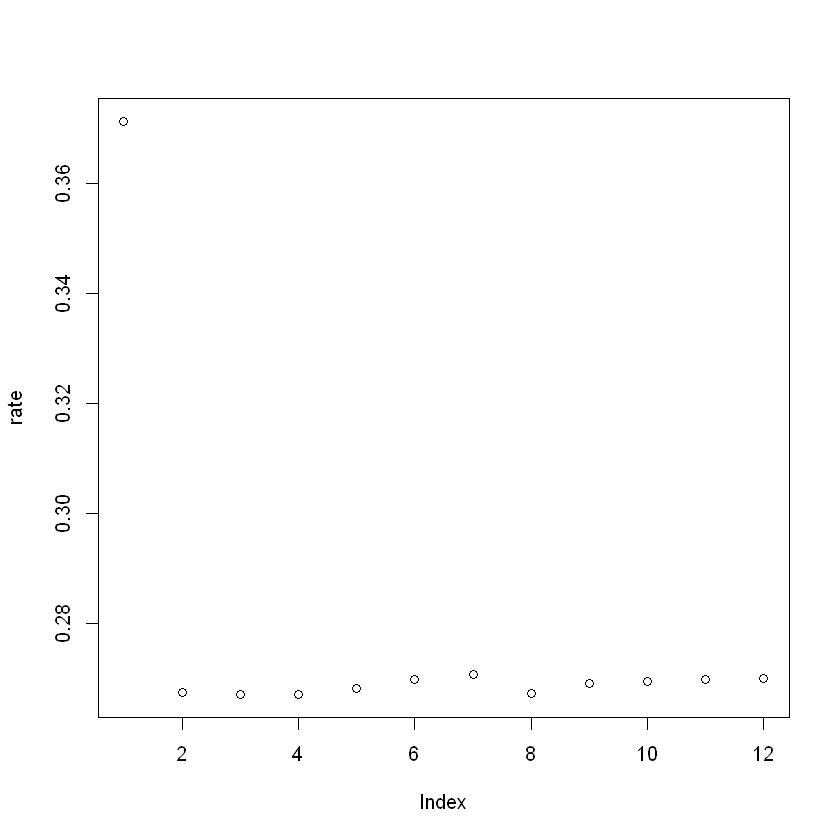

In [217]:
rate  
plot(rate)

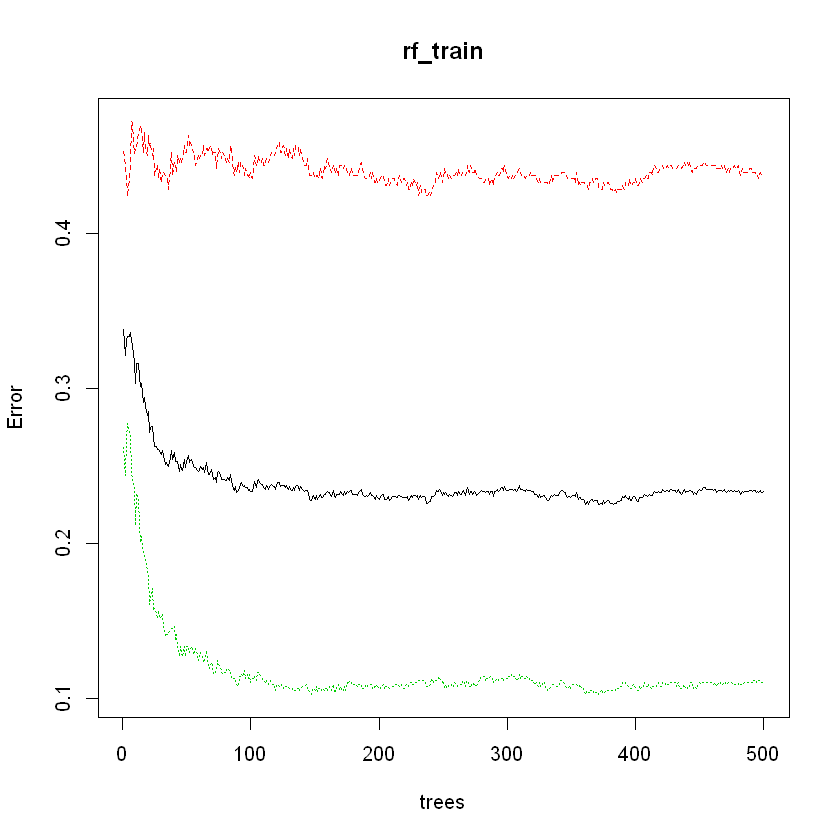

In [218]:
rf_train<-randomForest(as.factor(train$Y)~.,data=train,mtry=6)
plot(rf_train)    
legend(800,0.02,"Y=0",cex=0.9,bty="n")    
legend(800,0.0245,"total",cex=0.09,bty="n")   

In [142]:
set.seed(100)
rf_train<-randomForest(as.factor(train$Y)~.,data=as.data.frame(train),mtry = 6,importance=TRUE)
rf_train


Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = as.data.frame(train),      mtry = 6, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 23.97%
Confusion matrix:
    0   1 class.error
0 244 218   0.4718615
1  78 695   0.1009056

In [143]:
rf_pred = predict(rf_train, newdata = test)
(rf_acc = round(sum(rf_pred == test$Y)/length(rf_pred),4))

[1] 0.7601

,MeanDecreaseGini
Gender,7.296652
Average_GPA,120.375164
s_start_year,104.782834
s_Citizenship,8.620803
avs_net_cost,102.301805
Gender.1,7.294950
s_Average.Precol.GPA,54.221848
College,26.482746
funding_indicator,12.515407
Citizenship,54.840312


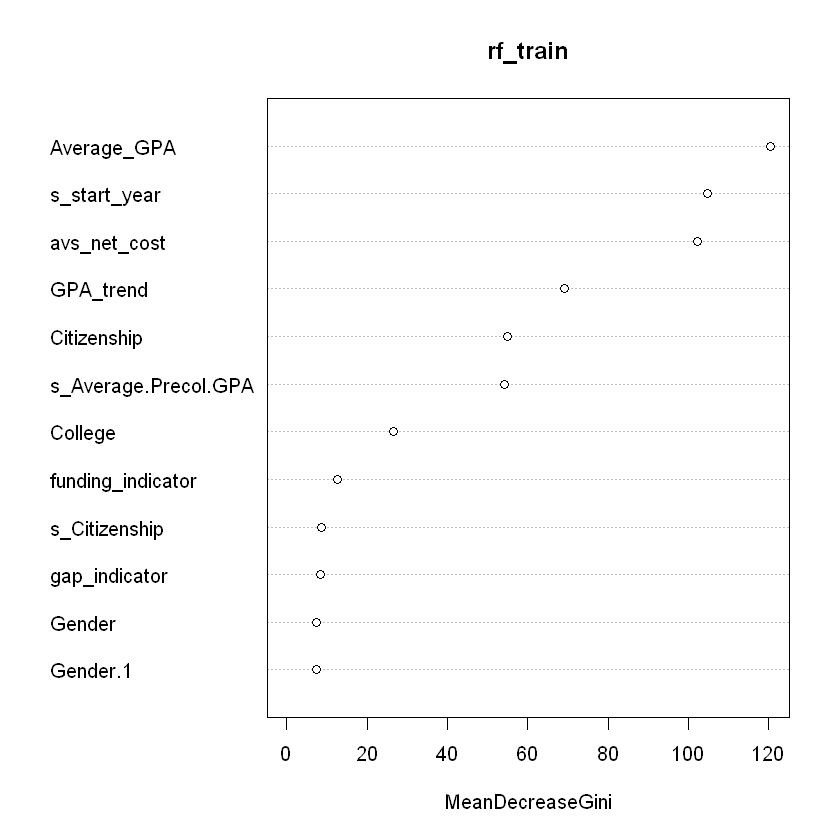

In [219]:
importance(rf_train)
varImpPlot(rf_train)

## LDA

In [122]:
mod_lda = lda(Y~., data = as.data.frame(train))
lda_pred = predict(mod_lda, newdata = test)

Warning message in lda.default(x, grouping, ...):
"variables are collinear"

In [123]:
(lda_acc = round(sum(lda_pred$class == test$Y)/length(lda_pred$class),4))

[1] 0.7164

<b> Summary

In [124]:
mod_lda$scaling

,LD1
GenderMale,0.15861060
Average_GPA,0.61905577
s_start_year,-0.75898310
s_CitizenshipAsia,-0.29331910
s_CitizenshipChina,-0.39924550
s_CitizenshipWhite,-0.83318958
avs_net_cost,0.10807050
Gender.1Male,0.15861060
s_Average.Precol.GPA,0.06589271
s_GRE.Combined.General.Write.Score,0.05595929


## Neural Network

In [125]:
nnet_vld = NULL
for (i in seq(1,20,1)){
    mod_nnet = nnet(Y~., data = train, size  = i,trace = FALSE, decay =.1, rang = 0, maxit = 250)
    nn_pred = predict(mod_nnet, newdata = vld)
    nn_pred = as.numeric(nn_pred>=.5)
    nnet_vld = c(nnet_vld, sum(nn_pred == vld$Y)/length(nn_pred))
}
(tr_size = which.max(nnet_vld))

[1] 2

In [126]:
mod_nnet = nnet(Y~., data = train, size  = tr_size,trace = FALSE, decay =.1, rang = 0, maxit = 250)
nn_pred = as.numeric(predict(mod_nnet, newdata = test)>= .5)

In [127]:
(nnet_acc = round(sum(nn_pred == test$Y)/length(nn_pred),4))

[1] 0.7229

<b> Summary

In [128]:
summary(mod_nnet)

a 31-2-1 network with 67 weights
options were - decay=0.1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  -3.40    0.01    1.62   -0.02   -0.37   -0.59   -1.30   -0.16    0.01   -0.06 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 i19->h1 
  -0.23    0.40    0.20   -1.36    4.69   -1.38   -0.59   -0.88   -1.20    0.41 
i20->h1 i21->h1 i22->h1 i23->h1 i24->h1 i25->h1 i26->h1 i27->h1 i28->h1 i29->h1 
  -0.37   -0.49    0.23   -0.59    0.26   -0.37   -0.28    0.17   -0.54   -0.29 
i30->h1 i31->h1 
   0.04   -0.36 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.34    0.28    0.34   -1.54   -0.07    0.16    0.07    0.93    0.28    0.12 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 i19->h2 
   0.28   -0.96   -0.26    0.69    0.97    0.02   -0.16    0.55    0.38    0.64 
i20->h2 i21->h2 i22->h2 i23->h2 i24->h2 i25->h2 i26->h2 i27->h2 i28->h2 i29->h2 
  -0.07    0.34  

## Logistic Regression

In [129]:
mod_glm = glm(Y~., data = train, family=binomial())
glm_pred = as.numeric(predict(mod_glm, newdata = test, type="response") >= .5)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

In [130]:
(glm_acc = round(sum(glm_pred == test$Y)/length(glm_pred),4))

[1] 0.7164

<b> Summary

In [131]:
summary(mod_glm)


Call:
glm(formula = Y ~ ., family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5222  -1.0673   0.6306   0.9005   2.6069  

Coefficients: (4 not defined because of singularities)
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.3519815  0.9476446  -1.427  0.15367
GenderMale                               0.2954337  0.1411657   2.093  0.03637
Average_GPA                              0.6377503  0.1173186   5.436 5.45e-08
s_start_year                            -0.7448138  0.0886730  -8.400  < 2e-16
s_CitizenshipAsia                       -0.6270261  0.5893894  -1.064  0.28739
s_CitizenshipChina                      -0.7642329  0.5909230  -1.293  0.19591
s_CitizenshipWhite                      -1.2021457  0.5632633  -2.134  0.03282
avs_net_cost                             0.1021013  0.0664638   1.536  0.12449
Gender.1Male                                    NA      

## SVM

In [132]:
mod_svm = svm(Y~., data = train, family=binomial())
svm_pred = as.numeric(predict(mod_svm, newdata = test, type="response") >= .5)

In [133]:
(svm_acc = round(sum(svm_pred == test$Y)/length(svm_pred),4))

[1] 0.7018

<b> Summary

In [134]:
summary(mod_svm)
colMeans(mod_svm$SV)
#The resulting support vectors (possibly scaled).


Call:
svm(formula = Y ~ ., data = train, family = binomial())


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.03125 
    epsilon:  0.1 


Number of Support Vectors:  1001






GenderFemale                              GenderMale 
                            0.464535465                             0.535464535 
                            Average_GPA                            s_start_year 
                           -0.060765320                             0.109074019 
                      s_CitizenshipAsia                      s_CitizenshipChina 
                            0.126873127                             0.134865135 
                     s_CitizenshipWhite                            avs_net_cost 
                            0.715284715                             0.015730675 
                           Gender.1Male                    s_Average.Precol.GPA 
                            0.535464535                             0.007453004 
     s_GRE.Combined.General.Write.Score       s_GRE.Combined.Quantitative.Score 
                            0.038540458                            -0.003145523 
    s_GRE.Combined.General.Verbal.Score                     CollegeGD.Education 
                            0.015069642                             0.027972028 
                  CollegeGD.Grad.School                        CollegeGD.Harpur 
                            0.023976024                             0.664335664 
                   CollegeGD.Management                       CollegeGD.Nursing 
                            0.022977023                             0.048951049 
                       CollegeGD.Watson                       funding_indicator 
                            0.199800200                            -0.015489173 
                        CitizenshipAsia                        CitizenshipAsian 
                            0.126873127                             0.040959041 
   CitizenshipBlack.or.African.American                        CitizenshipChina 
                            0.032967033                             0.134865135 
                      CitizenshipEurope           CitizenshipHispanic.or.Latino 
                            0.020979021                             0.039960040 
                       CitizenshipIndia CitizenshipOther.International.Students 
                            0.046953047                             0.016983017 
                     CitizenshipUnknown                        CitizenshipWhite 
                            0.066933067                             0.449550450 
                          gap_indicator                               GPA_trend 
                           -0.029448601                            -0.008512753

## LASSO

In [135]:
train_x = model.matrix(~., data = train_x)
test_x = model.matrix(~., data = test_x)

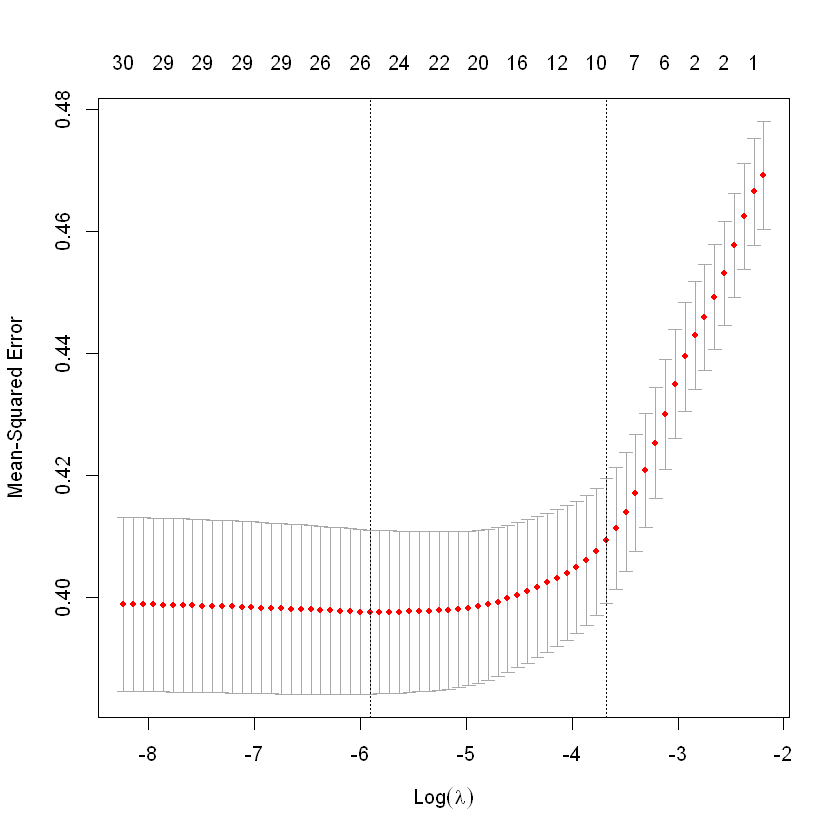

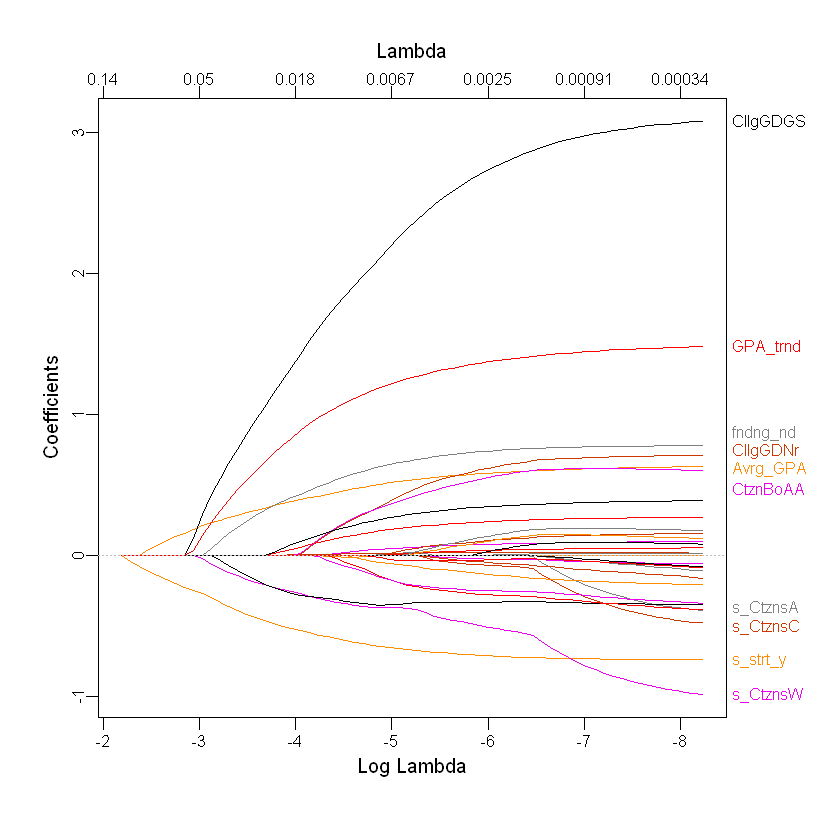

In [136]:
cvfit = cv.glmnet(train_x,train_y,alpha=1,family='binomial',type.measure='mse')
mod_lasso = glmnet(train_x,train_y,alpha=1, family = "binomial",lambda = cvfit$lambda)
plot(cvfit)
plot_glmnet(mod_lasso)
mod_lasso <- glmnet(train_x,train_y,alpha=1, family = "binomial",lambda = cvfit$lambda.min)

In [137]:
lasso_pred = predict(mod_lasso, test_x, type="class")
lasso_right = colSums(lasso_pred == test_y)
(lasso_acc = round(max(lasso_right)/length(test_y),4))

[1] 0.718

<b> Summary

In [138]:
mod_lasso$beta

32 x 1 sparse Matrix of class "dgCMatrix"
                                                  s0
(Intercept)                              .          
GenderMale                               0.064072188
Average_GPA                              0.580199378
s_start_year                            -0.707438846
s_CitizenshipAsia                        .          
s_CitizenshipChina                       .          
s_CitizenshipWhite                      -0.493806771
avs_net_cost                             0.077545147
Gender.1Male                             0.193333187
s_Average.Precol.GPA                     0.036061025
s_GRE.Combined.General.Write.Score       0.001396758
s_GRE.Combined.Quantitative.Score       -0.127946847
s_GRE.Combined.General.Verbal.Score      .          
CollegeGD Education                     -0.019215033
CollegeGD Grad School                    2.709025411
CollegeGD Harpur                        -0.325760503
CollegeGD Management                     .          
Coll

## Prediction Summary

In [146]:
res = data.frame(rbind(rf_acc, lda_acc, nnet_acc, glm_acc,svm_acc,lasso_acc))
colnames(res) = 'Accuracy'
rownames(res) = c('Random Forest','LDA', 'Neural Network', 'Logistic Regression', 'SVM', 'LASSO')
res

,Accuracy
Random Forest,0.7601
LDA,0.7164
Neural Network,0.7229
Logistic Regression,0.7164
SVM,0.7018
LASSO,0.7180


In [10]:
odds = exp(1.35*5)
p = (odds)/(1+odds)
odds

[1] 854.0588